In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from itertools import product
from tqdm.auto import tqdm

# Heat-bath algorithm

We want to sample the Ising Hamiltonian $H = -\sum_{\langle i,j \rangle} s_i s_j$ with the Boltzmann distribution $p(s) = e^{-\beta H(s)}$ with $\beta$ the inverse temperature.

The heat-bath algorithm selects a site at random and assign it to $+1$ with probability $p_+$ and to $-1$ with probability $p_-$, with:
\begin{align}
p_+ &= \frac 1 {1 + e^{-2 \beta h}} \\
p_- &= \frac 1 {1 + e^{+2 \beta h}}
\end{align}
where $h$ is the sum of the spins neighbors to the selected spins.

This algorithm statisfies the detailed balance. Let $s^-$ and $s^+$ be two configurations that differ by one spin (otherwise the transition probability is 0 and the detailed balance is trivially satisfied), with that spin being $-1$ in $s^-$ and $+1$ in $s^+$. Then, the effective field $h$ for that spin is the same for both configuration and:
\begin{align}
p(s^- \to s^+) &= \frac 1 {1 + e^{-2 \beta h}} \\
&= \frac {e^{-\beta H(s^+)}} {e^{-\beta H(s^-)} + e^{-\beta H(s^+)}} \\
p(s^+ \to s^-) &= \frac 1 {1 + e^{2 \beta h}} \\
&= \frac {e^{-\beta H(s^-)}} {e^{-\beta H(s^-)} + e^{-\beta H(s^+)}}
\end{align}
and thus we indeed have the detailed balance:
$$ \pi_{s^-} p(s^- \to s^+) = \pi_{s^+} p(s^+ \to s^-) $$

We can also notice that with the exception of the case $\beta = +\infty$, the markov chain defined by this algorithm is irreducible and aperiodic.

In [2]:
def heat_bath(config, beta, n_steps):
    """Performs n_steps steps of the heat-bath algorithm on a square lattice at inverse temperature beta"""
    n,m = config.shape
    for k in range(n_steps):
        i,j = np.random.randint(n), np.random.randint(m)
        h_eff = config[(i+1)%n,j] + config[(i-1)%n,j] + config[i,(j+1)%m] + config[i,(j-1)%m]
        if np.random.random() < 1 / (1 + np.exp(-2 * beta * h_eff)):
            config[i,j] = 1
        else:
            config[i,j] = -1

def dual_heat_bath(config_1, config_2, beta, n_steps):
    """Performs n_steps steps of the heat-bath algorithm on two configurations with the same choices of spins and same probabilities"""
    assert config_1.shape == config_2.shape
    n,m = config_1.shape
    for k in range(n_steps):
        
        i,j = np.random.randint(n), np.random.randint(m)
        
        h_eff_1 = config_1[(i+1)%n,j] + config_1[(i-1)%n,j] + config_1[i,(j+1)%m] + config_1[i,(j-1)%m]
        h_eff_2 = config_2[(i+1)%n,j] + config_2[(i-1)%n,j] + config_2[i,(j+1)%m] + config_2[i,(j-1)%m]
        
        p = np.random.random()
        
        if p < 1 / (1 + np.exp(-2 * beta * h_eff_1)):
            config_1[i,j] = 1
        else:
            config_1[i,j] = -1
        
        if p < 1 / (1 + np.exp(-2 * beta * h_eff_2)):
            config_2[i,j] = 1
        else:
            config_2[i,j] = -1

<IPython.core.display.Javascript object>


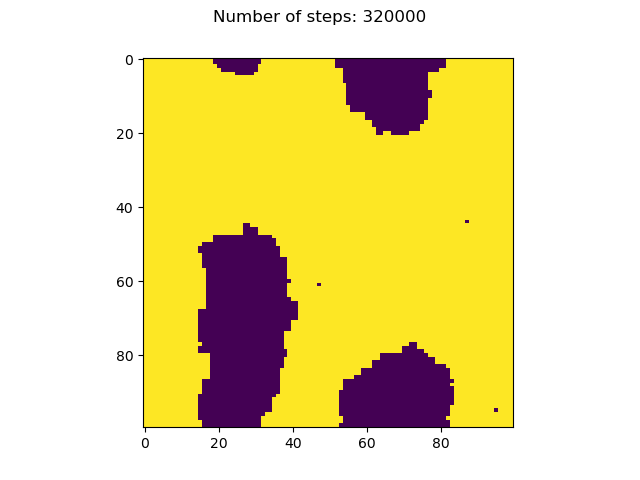

In [5]:
%matplotlib notebook

L = 100
#beta  = 1 / 2.27
beta = 1
n_steps = 10000

config = np.random.choice([-1,1], size=(L,L))

fig = plt.figure()
im = plt.imshow(config, vmin=-1, vmax=1, animated=True)

def update(k):
    fig.suptitle("Number of steps: {}".format(n_steps * k))
    heat_bath(config, beta, n_steps)
    im.set_array(config)
    return im,


ani = FuncAnimation(fig, update, frames=100, interval=100, blit=True)

plt.show()

<IPython.core.display.Javascript object>


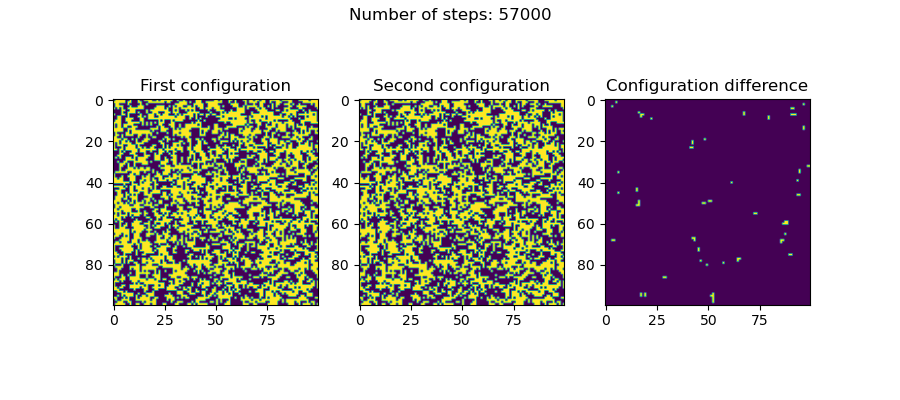

In [7]:
# In this cell, we observe that two initial configurations evolved with the heat-bath algorithm using the same choices of spin
# and the same randomly drawn number at each time step eventually become the same for a small enough beta

%matplotlib notebook

L = 100
#beta  = 1 / 2.27
beta = 0.2
n_steps = 1000

fig, ax = plt.subplots(1, 3, figsize=(9,4))

#config_1 = np.random.choice([-1,1], size=(L,L))
#config_2 = np.random.choice([-1,1], size=(L,L))

config_1 = np.full((L,L), 1)
config_2 = np.full((L,L), -1)

config_diff = abs(config_1 - config_2)

im1 = ax[0].imshow(config_1, vmin=-1, vmax=1, animated=True)
im2 = ax[1].imshow(config_2, vmin=-1, vmax=1, animated=True)
im3 = ax[2].imshow(config_diff, vmin=0, vmax=2, animated=True)

ax[0].set_title("First configuration")
ax[1].set_title("Second configuration")
ax[2].set_title("Configuration difference")

def update(k):
    fig.suptitle("Number of steps: {}".format(n_steps * k))
    dual_heat_bath(config_1, config_2, beta, n_steps)
    config_diff = abs(config_1 - config_2)
    im1.set_array(config_1)
    im2.set_array(config_2)
    im3.set_array(config_diff)
    return im1, im2, im3

ani = FuncAnimation(fig, update, frames=100, interval=100, blit=True)

plt.show()

# Coupling from the past with the Ising model

### Partial order of configurations

Let us define a partial order over configurations by:

$$ s \leq s' \iff \forall k, \ s_k \leq s'_k $$

We observe two facts about that order relation:
- If we denote by $s^-$ and $s^+$ the configurations with respectively all spins $-1$ and all spins $+1$, then for any configuration $s$ we have $s^- \leq s \leq s^+$
- Let $s(t)$ and $s'(t)$ be two sequences of configurations evolved with the heat-bath algorithm, where at each time step the choice of spin to flip $s_t$ and the sample $x_t$ from a uniform distribution over $[0,1]$ is the same. If $s(t) \leq s'(t)$, then the effective fields $h$ and $h'$ for the chosen spin $s_t$ will satisfy $h \leq h'$. This it turn implies that $p^+(s(t)) \leq p^+(s'(t))$. Since the random number $x_t$ used to determine the new state of spin $s_t$ is the same for both configurations, then we see that for all 3 possible cases the new spin $s_t$ of $s(t+1)$ is smaller or equal to the one in $s'(t+1)$. All other spins remaining the same, we thus have $s(t+1) \leq s'(t+1)$.

### Perfect sampling with heat-bath

Suppose that we have an evolution from time $-\infty$ with the heat-bath algorithm for some initial configuration $s(-\infty)$. This evolution is caracterized by a choice of spin to flip $s_t$ and a sample $x_t$ from a uniform distribution over $[0,1]$ to choose the new state of that spin, for all time steps $t \in \left]-\infty, 0\right]$. The markov chain being irreducible and aperiodic, the configuration $s(0)$ at time $0$ is distributed exactly according to the target distribution. We now want to sample those configurations by going back from time $0$ only a finite number of steps.

Suppose that we know of a time step $t_0 < 0$ such that if $s$ and $s'$ are two sequences of configurations for the same $\{s_t, x_t\}_{t\in\left]-\infty, 0\right]}$ with $s(t_0) = s^-$ and $s'(t_0) = s^+$, then $s(0) = s'(0) = s^f$. Then for any sequence of configuration $\sigma$ we have $s(t_0) \leq \sigma(t_0) \leq s'(t_0)$ and thus $s(0) \leq \sigma(0) \leq s'(0)$, meaning that $\sigma(0) = s^f$. In other words, if we reach a negative time $t_0$ such that both $s^+$ and $s^-$ are evolved to the same state $s^f$, then any initial state at $-\infty$ would have evolved to $s^f$ at time $0$. This state is therefore effectively the result of the evolution of any initial condition from $-\infty$, and it is thus exactly sampled according to the equilibrium distribution.

In [2]:
def ising_perfect_sampling(beta, n, m):
    """Return a sample from the Boltzmann distribution from the Ising model at inverse temperature beta 
    on a lattice with (n,m) using the coupling from the past algorithm"""
    
    choices = []
    have_reached_t0 = False
    
    while not have_reached_t0:
            
        # Define the spin choice and random number for the current time
        spin_choice = np.random.randint(n), np.random.randint(m)
        random_number = np.random.random()
        choices.insert(0, (spin_choice, random_number))
        
        # Check if s^+ and s^- at the current time evolve to the same configuration at time 0
        config_plus = np.ones((n,m))
        config_minus = -np.ones((n,m))
        
        for choice in choices:
            
            (i,j), p = choice
            h_plus = config_plus[(i+1)%n,j] + config_plus[(i-1)%n,j] + config_plus[i,(j+1)%m] + config_plus[i,(j-1)%m]
            h_minus = config_minus[(i+1)%n,j] + config_minus[(i-1)%n,j] + config_minus[i,(j+1)%m] + config_minus[i,(j-1)%m]
            
            if p < 1 / (1 + np.exp(-2 * beta * h_plus)):
                config_plus[i,j] = 1
            else:
                config_plus[i,j] = -1
            
            if p < 1 / (1 + np.exp(-2 * beta * h_minus)):
                config_minus[i,j] = 1
            else:
                config_minus[i,j] = -1
        
        if (config_plus == config_minus).all():
            have_reached_t0 = True
        
    return config_plus


def config_energy(config):
    """Return the energy of the configuration"""
    energy = 0
    n,m = config.shape
    for i in range(n):
        for j in range(m):
            energy += -(config[(i+1)%n,j] + config[(i-1)%n,j] + config[i,(j+1)%m] + config[i,(j-1)%m]) * config[i,j]
    return energy / 2

  0%|          | 0/10000 [00:00<?, ?it/s]

Average absolute value difference: 0.00189


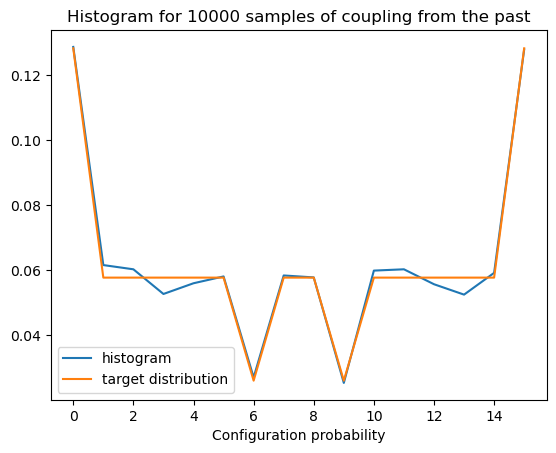

In [3]:
beta = 0.1
n = 2
m = 2
n_samples = 10000

combination_list = list(product([-1, 1], repeat=n*m))
combination_dict = {combination: k for k, combination in enumerate(combination_list)}

config_list = [np.array(combination).reshape(n,m) for combination in combination_list]
config_energies = [config_energy(config) for config in config_list]
config_proba = np.exp(-beta * np.array(config_energies))
config_proba /= np.sum(config_proba)

samples = [combination_dict[tuple(list(ising_perfect_sampling(beta, n, m).flatten()))] for k in tqdm(range(n_samples))]
histogram = np.array([samples.count(k) for k in range(len(combination_list))]) / n_samples

plt.plot(histogram, label='histogram')
plt.plot(config_proba, label='target distribution')

plt.legend()
plt.title("Histogram for {} samples of coupling from the past".format(n_samples))
plt.xlabel("Configuration index")
plt.xlabel("Configuration probability")
print("Average absolute value difference: {:.3}".format(np.sum(abs(config_proba - histogram)) / len(config_proba)))